In [32]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [33]:
import numpy as np
import pandas as pd

In [34]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [35]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [36]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [37]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [38]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [39]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [40]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [41]:
#inspect measurement table 
first = session.query(Measurement).first()
first.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x143b8de5320>,
 'tobs': 65.0,
 'prcp': 0.08,
 'id': 1,
 'date': '2010-01-01',
 'station': 'USC00519397'}

# Exploratory Climate Analysis¶

In [42]:
# Calculate the date 1 year ago from the last data point in the database
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
latest_date[0]

'2017-08-23'

In [43]:
# Calculate the latest date of the prior year  
latest_list = latest_date[0].split("-")
latest_list[0] = str(int(latest_list[0]) - 1)
year_prior = "-".join(latest_list)
year_prior

'2016-08-23'

In [48]:
# Sort the dataframe by date and Perform a query to retrieve the data and precipitation scores 
last_12 = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > year_prior)
last_12_df = pd.read_sql_query(last_12.statement, engine, index_col="date")
last_12_df.head()

,prcp
date,
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
2016-08-28,0.01


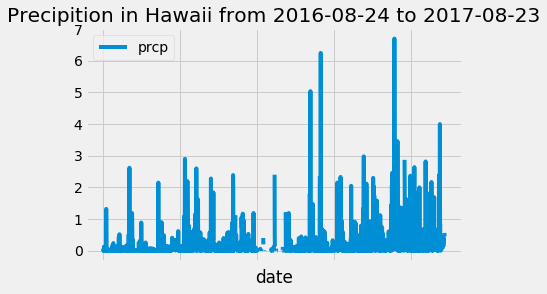

In [45]:
# Use Pandas Plotting with Matplotlib to plot the data
last_12_df.plot(rot=45)
plt.title("Precipition in Hawaii from %s to %s" % (last_12_df.index.min(),last_12_df.index.max()))
plt.show()

In [46]:
# Use Pandas to calcualte the summary statistics for the precipitation data
last_12_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [52]:
# Design a query to show how many stations are available in this dataset?
num_stations = session.query(Station.station).count()
num_stations

9

In [121]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.tobs)).filter(Station.station == Measurement.station).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()  
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [122]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
low_activity = active_stations[8][0:2]
low_activity

('USC00518838', 511)

In [123]:
# highest temperature recorded, and average temperature most active station?
most_activity = active_stations[0][0:2]
most_activity

('USC00519281', 2772)

In [124]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station.
waihee_tobs = session.query(Measurement.tobs).\
filter(Measurement.station == "USC00519281", Measurement.station == Station.station, Measurement.date >="2016-08-23", Measurement.date <="2017-08-23").\
all()

In [125]:
len(waihee_tobs)

352

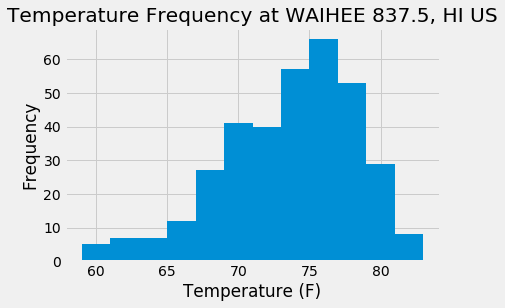

In [94]:
#Plot the results as a histogram
temps = [x[0] for x in waihee_tobs]
plt.hist(temps, bins=12)
plt.xlabel("Temperature (F)")
plt.ylabel("Frequency")
plt.title("Temperature Frequency at %s" % (most_activity[1]))
plt.show()

In [127]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [128]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
Temp=[]
start_date='2016-08-01'
end_date='2017-08-01'
def calc_temps(start_date, end_date):
    results=session.query(func.max(Measurement.tobs).label("max_tobs"), \
                          func.min(Measurement.tobs).label("min_tobs"),\
                          func.avg(Measurement.tobs).label("avg_tobs")).\
                          filter(Measurement.date.between(start_date , end_date))  
    res = results.one()
    res
    
    TMAX = res.max_tobs
    TMIN= res.min_tobs
    TAVG= res.avg_tobs
    Temp.append(TMAX)
    Temp.append(TMIN)
    Temp.append(TAVG)

calc_temps(start_date, end_date)
Temp

[87.0, 58.0, 74.64288840262581]

In [129]:
TAVG=Temp[2]
TMIN=Temp[1]
TMAX=Temp[0]

C:\Users\user\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


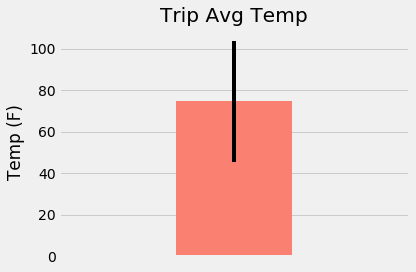

In [130]:
# Plot the results from your previous query as a bar chart.# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value, # Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig = plt.figure()
plt.bar( 1,TAVG, color = 'salmon', yerr = TMAX-TMIN, align='center')
plt.xlim(-0.2, 2.2)
plt.ylim([0, 110])
plt.axes().get_xaxis().set_visible(False)
plt.title('Trip Avg Temp')
plt.ylabel("Temp (F)")
plt.tight_layout()
plt.show()
fig.savefig('Trip Avg Temp.png', dpi=fig.dpi)

In [119]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
Rainfall_results = session.query(Station.station, Station.name, Measurement.station, func.count(Measurement.prcp)).\
                   group_by(Measurement.station).filter(Measurement.date.between('2016-08-01', '2017-08-01')).all()
Rainfall_results

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 'USC00513117', 3285),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 'USC00514830', 2349),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 'USC00516128', 2979),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 'USC00517948', 603),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 'USC00519281', 3285),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 'USC00519397', 3249),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 'USC00519523', 2880)]

## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


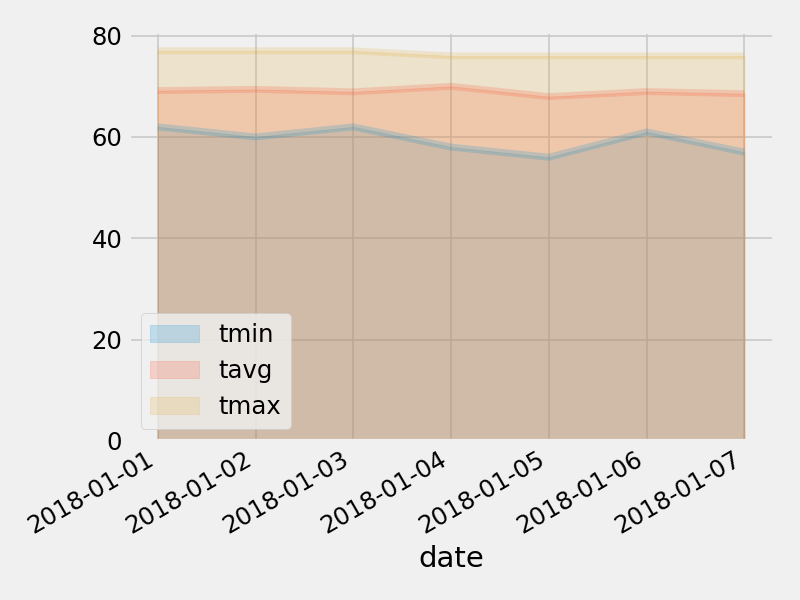

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
